In [1]:
sales = pd.read_csv(r"C:\Users\SARVESH\Documents\GitHub\Sales Prediction\sales_train_v2.csv")
test = pd.read_csv(r"C:\Users\SARVESH\Documents\GitHub\Sales Prediction\test_time.csv")
item_cat = pd.read_csv(r"C:\Users\SARVESH\Documents\GitHub\Sales Prediction\item_categories.csv")
item = pd.read_csv(r"C:\Users\SARVESH\Documents\GitHub\Sales Prediction\items.csv")
shops = pd.read_csv(r"C:\Users\SARVESH\Documents\GitHub\Sales Prediction\shops.csv")
sub = pd.read_csv(r"C:\Users\SARVESH\Documents\GitHub\Sales Prediction\sample_sub.csv")  
                   

In [2]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [3]:
#formatting the date column correctly
import datetime
sales.date = sales.date.apply(lambda x :datetime.datetime.strptime(x , '%d.%m.%Y'))
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [4]:
sales.shape

(2935849, 6)

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


# Data: We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

In [7]:
#Aggregate to monthly level the required metrics
monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date':['min','max'],
                                                                       'item_price':'mean',
                                                                       'item_cnt_day':'sum'})
## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [8]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

In [9]:
monthly_sales.tail()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

In [11]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Text(0.5, 0, 'Item category')

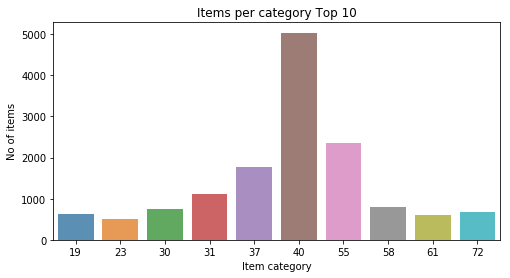

In [15]:
#number of items per category
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by = 'item_id', ascending = False)
x = x.iloc[0:10].reset_index()
plt.figure(figsize = (8,4))
ax = sns.barplot(x.item_category_id ,x.item_id, alpha =0.8)
plt.title('Items per category Top 10')
plt.ylabel('No of items')
plt.xlabel('Item category')

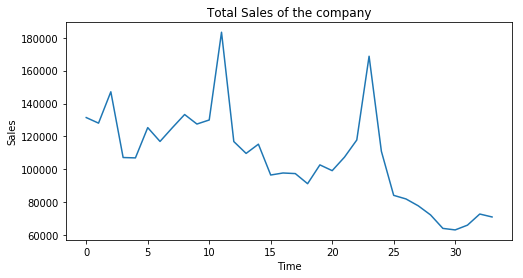

In [21]:
#Plot for sales per month for the entire company

ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype(float)
plt.figure(figsize=(8,4))
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Total Sales of the company')
plt.show()

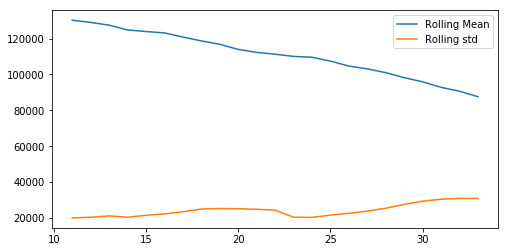

In [20]:
plt.figure(figsize=(8,4))
plt.plot(ts.rolling(window = 12,center  = False).mean(),label = 'Rolling Mean')
plt.plot(ts.rolling(window = 12, center = False).std(),label = 'Rolling std')
plt.legend()

# Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend"

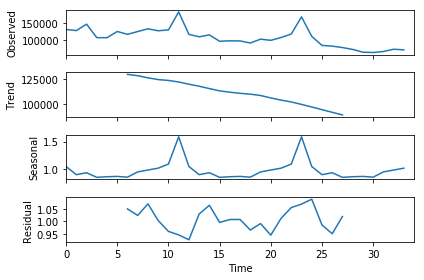

In [25]:
#multiplicative model
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values , freq = 12 , model = 'multiplicative')
fig = res.plot()


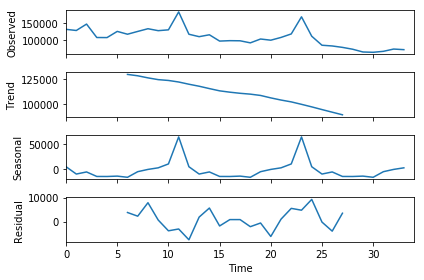

In [26]:
#additive model
res = sm.tsa.seasonal_decompose(ts.values , freq = 12 , model = 'additive')
fig = res.plot()

In [28]:
#Check Stationarity 
from statsmodels.tsa.stattools import adfuller , acf , pacf , arma_order_select_ic
def test_stationarity(timeseries):
    
    #Perform Dickey Fuller test
    print("Results of the Dickey Fuller TEST")
    dftest = adfuller(timeseries , autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)
    

Results of the Dickey Fuller TEST
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [29]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

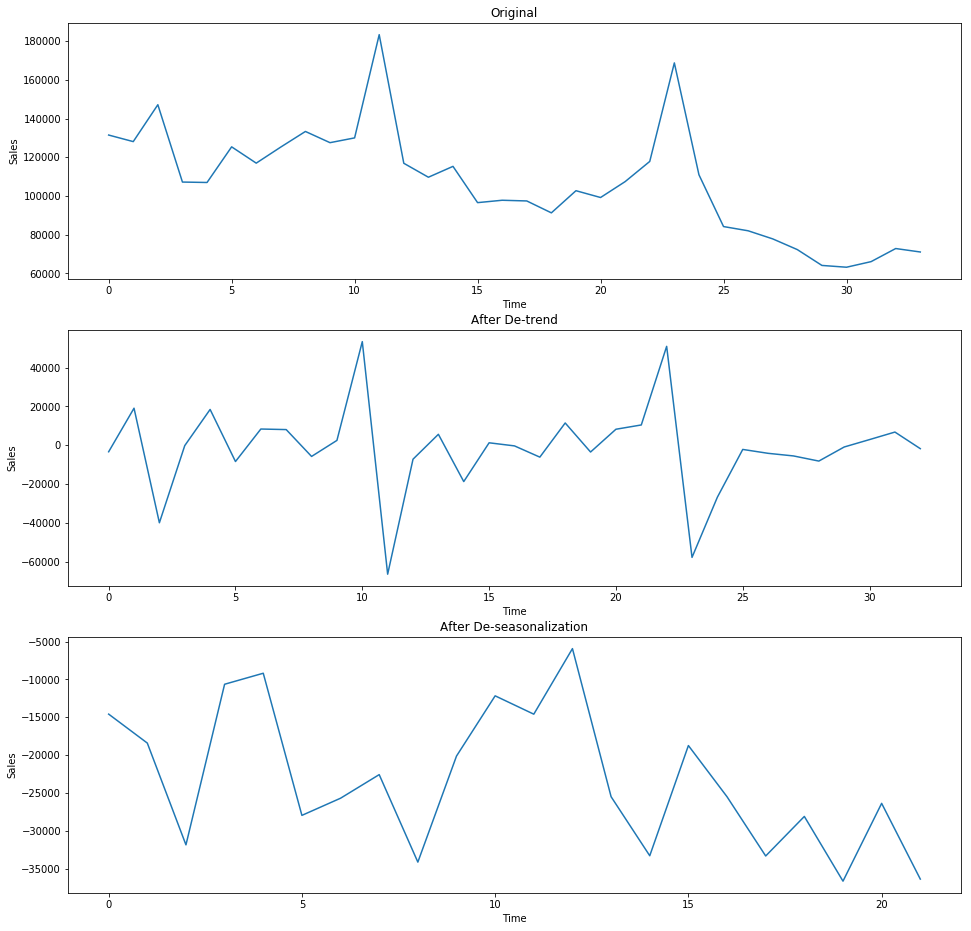

In [33]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [34]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of the Dickey Fuller TEST
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


# After transformation our p-value for the DF test is well below 5%. Hence we can assume stationarity of the series

# AR, MA and ARMA models

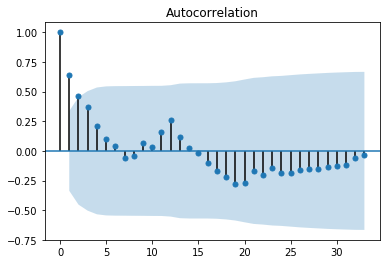

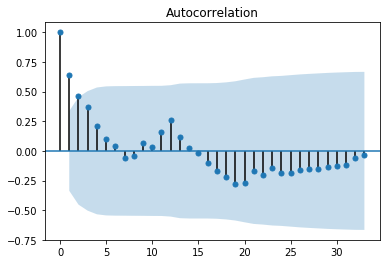

In [36]:
#Check Stationarity of Time Series
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts)

In [38]:
#Integrated of order 1, d = 1 , one of the parameter of ARIMA model
sales_diff = ts.diff(periods=1)
sales_diff = sales_diff[1:]
sales_diff.head()

date_block_num
1    -3389.0
2    19052.0
3   -39952.0
4     -220.0
5    18411.0
Name: item_cnt_day, dtype: float64

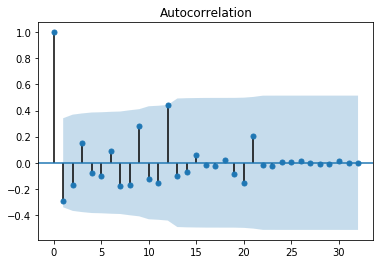

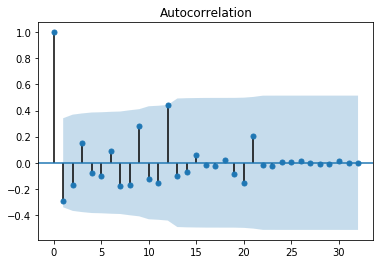

In [39]:
plot_acf(sales_diff)